In [3]:
from itertools import product
from collections import namedtuple
import csv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Import Data

In [4]:
FILE_NAME = 'abstracts_all.txt'

In [5]:
def get_data(stem=False):
    """Return abstracts and their subject label.
    
        Arguments:
            stem -- bool, stem words when True
        
        Returns:
            data_arr -- np array, each row is an abstract as a string
            category_arr -- np array, each entry is an abstract category
    """
    porter = PorterStemmer()
    with open(FILE_NAME, 'r') as file:
        csv_reader = csv.reader(file)
        data_ls, category_ls = [], []
        for row in csv_reader:
            category_ls.append(row[0])
            data = row[1:]
            if stem:
                data = [porter.stem(word) for word in data]
            data_ls.append(' '.join(data))
    return np.array(data_ls), np.array(category_ls)

## Not Stemmed Abstracts

In [6]:
# Get abstracts and their labels
abstract_arr, category_arr = get_data()

# Peek the data
print(f'Abstract: {abstract_arr[0]}\nSubject: {category_arr[0]}')

# Number of examples
print(f'\nNumber of abstracts: {len(abstract_arr)}')

Abstract: drought one devastating environmental disasters analyzing historical changes climate extremes critical mitigating adverse impacts future present study spatial temporal characteristics global severe droughts using palmer drought intensity index pdsi explored clustering implemented partition extreme negative pdsi values global extreme droughts magnitude around world less intense compared decades largest areas around world especially canada experienced severe historical droughts results show recent extreme droughts occurred regions north canada central regions us southwest europe southeast asia found spatial extent regions experienced extreme drought increased substantially
Subject: AP

Number of abstracts: 2686


## Stemmed Abstracts

In [7]:
# Get abstracts and their labels
abstract_arr_stem, _ = get_data(stem=True)  # categories are the same

# Peek the data
print(f'Abstract: {abstract_arr_stem[0]}\nSubject: {category_arr[0]}')

Abstract: drought one devast environment disast analyz histor chang climat extrem critic mitig advers impact futur present studi spatial tempor characterist global sever drought use palmer drought intens index pdsi explor cluster implement partit extrem neg pdsi valu global extrem drought magnitud around world less intens compar decad largest area around world especi canada experienc sever histor drought result show recent extrem drought occur region north canada central region us southwest europ southeast asia found spatial extent region experienc extrem drought increas substanti
Subject: AP


## Categories

In [8]:
categories, counts = np.unique(category_arr, return_counts=True)

# Categories
print(f'Categories: {categories}')

# Occurence of each subject
for sub, ct in zip(categories, counts):
    print(f'Occurence of {sub}: {ct} - {(ct / len(category_arr))*100:.2f}%')

Categories: ['AP' 'CO' 'ME' 'ML' 'OT' 'ST']
Occurence of AP: 425 - 15.82%
Occurence of CO: 167 - 6.22%
Occurence of ME: 605 - 22.52%
Occurence of ML: 900 - 33.51%
Occurence of OT: 38 - 1.41%
Occurence of ST: 551 - 20.51%


## Label Encode Targets

In [9]:
le = LabelEncoder()
y = le.fit_transform(category_arr)

# Subjects
print(f'Subjects: {le.classes_}')

Subjects: ['AP' 'CO' 'ME' 'ML' 'OT' 'ST']


# Best Model

In [8]:
def get_best_model(data_ls, clf_ls, transform_ls=None, verbose=True):
    """Returns the best model as determined by 10-fold cross validation.
    
        Arguments:
            data_ls -- list of named tuples TrainData('type', 'X', 'y')
            clf_ls -- list of sklearn classifiers with hyperparameters set [MultinomialNB(), RandomForestClassifier(n_estimators=100), ...]
            transform_ls -- (optional) list of tuples containg sklearn transformation objects to be implemented on the training features
            verbose -- (optional) boolean to print out results of each model
        
        Returns:
            best_model -- sklearn Pipeline of transforms with a final classifier
            best_data -- namedtuple containing data that performed the best under the specified models
            best_score -- highest average cross validation score
    """
    best_model, best_score, best_data = None, 0, None
    for data, transform, clf in product(data_ls, transform_ls, clf_ls):
        X, y = data.X, data.y
        model = make_pipeline(*transform, clf)
        avg_score = cross_val_score(model, X, y, cv=10).mean()
        if verbose:
            steps = list(model.named_steps.keys())
            print(f'Classifier: {steps[-1]} \nTransform(s): {steps[:-1]} \n10-fold CV avg acc: {avg_score:.4f}\n')
        if avg_score > best_score:
            best_score = avg_score
            best_model = model
            best_data = data
    if verbose:
        steps = list(best_model.named_steps.keys())
        print(f'Best classifier: {steps[-1]} with transformations: {steps[:-1]} and data: {best_data.type}\nAccuracy: {best_score:.4f}')
    return best_model, best_data, best_score

In [9]:
# Feature Transformation
transform_ls = [(CountVectorizer(),), (TfidfVectorizer(),)]

# Classifier
clf_ls = [MultinomialNB(), RandomForestClassifier(n_estimators=100, n_jobs=-1)]

In [10]:
# Data
TrainData = namedtuple('TrainData', ['type', 'X', 'y'])
data_ls = [TrainData('no_stem', abstract_arr, y), TrainData('stem', abstract_arr_stem, y)]

In [11]:
# Best model
best_model, best_data, _ = get_best_model(data_ls, clf_ls, transform_ls)

Classifier: multinomialnb 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6672

Classifier: randomforestclassifier 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6091

Classifier: multinomialnb 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.5208

Classifier: randomforestclassifier 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.6251

Classifier: multinomialnb 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6736

Classifier: randomforestclassifier 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6133

Classifier: multinomialnb 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.5100

Classifier: randomforestclassifier 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.6162

Best classifier: multinomialnb with transformations: ['countvectorizer'] and data: stem
Accuracy: 0.6736


# Confusion Matrix

In [1]:
def make_confusion_matrix(model, X, y, le, cbar=True, cmap='YlGn'):
    """Create a confusion matrix to visualize classification results.
    
        Arguements:
            model -- sklearn classifier or pipeline, object that has fit and predict methods
            X -- 2D numpy array, shape = [n_samples, n_features]
                Training vectors
            y -- array_like, shape = [n_samples]
                Target values
            le -- sklearn LabelEncoder
        
        Returns:
            fig -- Figure object
                figure of heatmap
            ax -- Axes object
                axes of heatmap
    
    """
    y_pred = model.fit(X, y).predict(X)
    mat = confusion_matrix(y, y_pred)
    mat = mat / mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(dpi=200)
    sns.heatmap(mat, square=True, annot=True, fmt='.2f', cbar=cbar, vmax=1, cmap=cmap,
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_title('Confusion Matrix, Normalized', fontweight='bold')
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    num_classes = len(le.classes_)
    ax.set_yticks(np.arange(0.5, num_classes, 1))
    ax.set_ylim([num_classes, 0])
    ax.set_yticklabels(le.classes_)
    return fig, ax

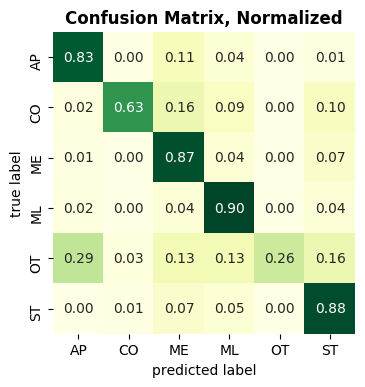

In [13]:
# Visualize predictive accuracy
fig, ax = make_confusion_matrix(best_model, best_data.X, best_data.y, le)

Here we can see that out of all the abstracts labeled 'OT', the model only correctly classified 26% of them. This makes sense because this label refers to 'other' which could be a combination of categories.  
Let us see how the model performs with all abstracts labeled 'OT' removed.

# Remove OT

## Filter Data

In [15]:
# Boolean mask
mask = category_arr != 'OT'
print(f"Number of 'OT' subjects to remove: {sum(~mask)}")

Number of 'OT' subjects to remove: 38


In [16]:
# Filter
abstract_arr = abstract_arr[mask]
abstract_arr_stem = abstract_arr_stem[mask]
category_arr = category_arr[mask]

## Label Encode Targets

In [17]:
le = LabelEncoder()
y = le.fit_transform(category_arr)

## Best Model

In [17]:
# Get best model
data_ls = [TrainData('no_stem', abstract_arr, y), TrainData('stem', abstract_arr_stem, y)]
best_model, best_data, _ = get_best_model(data_ls, clf_ls, transform_ls)

Classifier: multinomialnb 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6779

Classifier: randomforestclassifier 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6174

Classifier: multinomialnb 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.5302

Classifier: randomforestclassifier 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.6310

Classifier: multinomialnb 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6828

Classifier: randomforestclassifier 
Transform(s): ['countvectorizer'] 
10-fold CV avg acc: 0.6198

Classifier: multinomialnb 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.5192

Classifier: randomforestclassifier 
Transform(s): ['tfidfvectorizer'] 
10-fold CV avg acc: 0.6304

Best classifier: multinomialnb with transformations: ['countvectorizer'] and data: stem
Accuracy: 0.6828


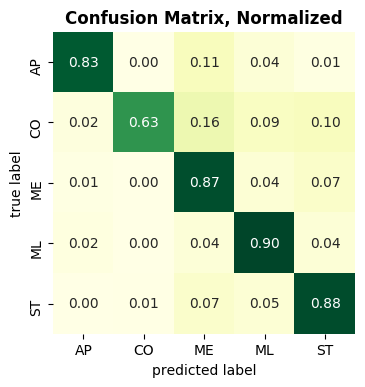

In [18]:
# Visualize predictive accuracy
fig, ax = make_confusion_matrix(best_model, best_data.X, best_data.y, le)

With 'OT' removed we can see that the model accurately predicts each category. There is a slight exception of 'CO', which out the remaining categories, has the least available examples with about 250 less examples than the second least occuring category.